# Packages and Files

In [ ]:
!pip install torch
!pip install torchinfo

In [24]:
import os
import sys
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

torch.backends.cudnn.deterministic = True

In [22]:
import zipfile

zip_file_path = 'data_p1.zip'  # Replace with the path to your zip file
extraction_dir = 'data_p1' # Replace with your desired extraction directory

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_dir, exist_ok=True)

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_dir)
    print(f"Successfully extracted '{zip_file_path}' to '{extraction_dir}'")
except FileNotFoundError:
    print(f"Error: Zip file not found at '{zip_file_path}'")
except zipfile.BadZipFile:
    print(f"Error: '{zip_file_path}' is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully extracted 'data_p1.zip' to 'data_p1'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [26]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: linux
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
---
matplotlib version: 3.10.0
pandas version: 2.2.2
PIL version: 11.3.0
torch version: 2.9.0+cpu
torchvision version: 0.24.0+cpu


## Device Check

In [29]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


# Preparing the data

In [34]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [35]:
# Define transformation to apply to the images
transform = transforms.Compose(
    [
        ConvertToRGB(),  # Convert images to RGB format if not already
        transforms.Resize((224, 224)),  # Resize images to 224x224
        # Convert images to tensors
        transforms.ToTensor()

    ]
)

print(type(transform))
print(transform)

<class 'torchvision.transforms.transforms.Compose'>
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [41]:
data_dir = 'data_p1/data_p1/data_multiclass'
train_dir = os.path.join(data_dir, "train")
print("Will read data from", train_dir)

Will read data from data_p1/data_p1/data_multiclass/train


In [42]:
# Load the dataset using `ImageFolder`
dataset = datasets.ImageFolder(root=train_dir, transform=transform)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 32000
    Root location: data_p1/data_p1/data_multiclass/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [43]:
dataset.classes

['cracks', 'no_cracks']

In [44]:
im = dataset.imgs
print(im[0])

distinct_classes = {x[1] for x in im}
print(distinct_classes)

('data_p1/data_p1/data_multiclass/train/cracks/C00001.jpg', 0)
{0, 1}


In [45]:
dataset = datasets.ImageFolder(root = train_dir, transform = transform)

In [46]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=g)

In [47]:
print(f"Length of training set: {len(train_dataset)}")
print(f"Length of validation set: {len(val_dataset)}")

Length of training set: 25600
Length of validation set: 6400


In [49]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [50]:
train_counts = class_counts(train_dataset)
train_counts

  0%|          | 0/25600 [00:00<?, ?it/s]

,0
cracks,12789
no_cracks,12811


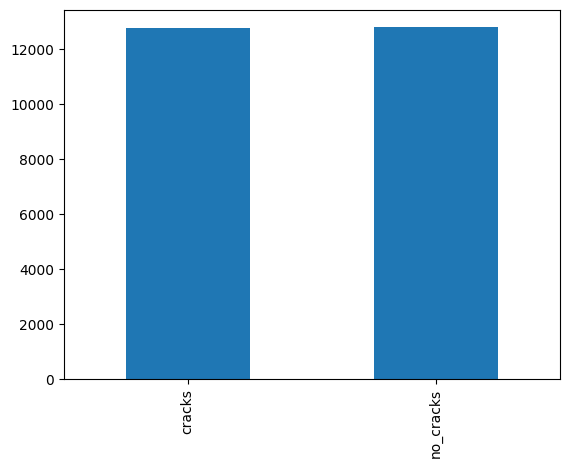

In [51]:
train_counts.sort_values().plot(kind="bar");

  0%|          | 0/6400 [00:00<?, ?it/s]

<Axes: >

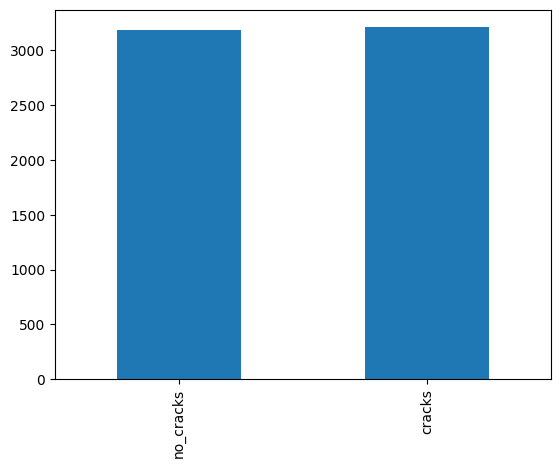

In [53]:
val_counts = class_counts(val_dataset)
val_counts.sort_values().plot(kind = "bar")

# Make a bar chart from the function output


In [52]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)

val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [55]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# This gives you [batch_size, channels, height, width] for images
image_shape = images.shape
print("Shape of batch of images", image_shape)

# This gives you [batch_size] for labels
label_shape = labels.shape
print("Shape of batch of labels:", label_shape)

Shape of batch of images torch.Size([32, 3, 224, 224])
Shape of batch of labels: torch.Size([32])


In [56]:
flatten = nn.Flatten()
tensor_flatten = flatten(images)

# Print the shape of the flattened tensor
print("Shape of the flattened tensor:", tensor_flatten.shape)

Shape of the flattened tensor: torch.Size([32, 150528])


In [57]:
# Image size from our transformer
height = 224
width = 224

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * height * width, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
)

print("model type:", type(model))
print("model structure:")
print(model)

model type: <class 'torch.nn.modules.container.Sequential'>
model structure:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
)


In [58]:
output_layer = nn.Linear(128,2)
model.append(output_layer)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)


In [59]:
model.to(device)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)


In [60]:
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 2]                   --
├─Flatten: 1-1                           [32, 150528]              --
├─Linear: 1-2                            [32, 512]                 77,070,848
├─ReLU: 1-3                              [32, 512]                 --
├─Linear: 1-4                            [32, 128]                 65,664
├─ReLU: 1-5                              [32, 128]                 --
├─Linear: 1-6                            [32, 2]                   258
Total params: 77,136,770
Trainable params: 77,136,770
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.47
Input size (MB): 19.27
Forward/backward pass size (MB): 0.16
Params size (MB): 308.55
Estimated Total Size (MB): 327.98

# Training the Models

In [61]:
loss_fn = nn.CrossEntropyLoss()

In [62]:
# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:
def train_epoch(model, optimizer, loss_fn, data_loader, device="cpu"):
    # We'll report the loss function's average value at the end of the epoch.
    training_loss = 0.0

    # The train method simply sets the model in training mode. No training
    # has happened.
    model.train()

    # We iterate over all batches in the training set to complete one epoch
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        # Sets the gradients to zero. We need to do this every time.
        optimizer.zero_grad()

        # Unpack images (X) and labels (y) from the batch and add those
        # tensors to the specified device.
        inputs = inputs.to(device)
        targets = targets.to(device)

        # We make a forward pass through the network and obtain the logits.
        # With the logits, we can calculate our loss.
        output = model(inputs)
        loss = loss_fn(output, targets)

        # After calculating our loss, we calculate the numerical value of
        # the derivative of our loss function with respect to all the
        # trainable model weights. Once we have the gradients calculated,
        # we let the optimizer take a "step", in other words, update or
        # adjust the model weights.
        loss.backward()
        optimizer.step()

        # We increment the training loss for the current batch
        training_loss += loss.data.item() * inputs.size(0)

    # We calculate the training loss over the completed epoch
    return training_loss / len(data_loader.dataset)

In [64]:
loss_value = train_epoch(model, optimizer, loss_fn, train_loader, device)
print(f"The average loss during the training epoch was {loss_value:.2f}.")

Training:   0%|          | 0/800 [00:00<?, ?it/s]

The average loss during the training epoch was 0.97.


In [ ]:
loss_value = train_epoch(model, optimizer, loss_fn, train_loader, device)
print(f"The average loss during the training epoch was {loss_value:.2f}.")

Training:   0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
def predict(model, data_loader, device="cpu"):
    # This tensor will store all of the predictions.
    all_probs = torch.tensor([]).to(device)

    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    model.eval()

    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():

        # Again, we iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            # The model produces the logits.  This softmax function turns the
            # logits into probabilities.  These probabilities are concatenated
            # into the `all_probs` tensor.
            probs = F.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs

In [ ]:
probabilities_train = predict(model, train_loader, device)
print(probabilities_train.shape)

In [ ]:
len(train_loader.dataset)

In [ ]:
probabilities_val = ...
print(probabilities_val.shape)

In [ ]:
print(probabilities_train[0])

In [ ]:
probabilities_train[0].sum()

In [ ]:
total_probability = ...
print(f"Sum of probabilities: {total_probability.item()}")

In [ ]:
predictions_train = torch.argmax(probabilities_train, dim=1)

print(f"Predictions shape: {predictions_train.shape}")
print(f"First 10 predictions: {predictions_train[:10]}")

In [ ]:
predictions_val = ...

print(f"Predictions shape: {predictions_val.shape}")
print(f"First 10 predictions: {predictions_val[:10]}")

In [ ]:
targets_train = torch.cat([labels for _, labels in train_loader]).to(device)
is_correct_train = torch.eq(predictions_train, targets_train)
total_correct_train = torch.sum(is_correct_train).item()
accuracy_train = total_correct_train / len(train_loader.dataset)

print(f"Accuracy on the training data: {accuracy_train}")

In [ ]:
targets_val = ...
is_correct_val = ...
total_correct_val = ...
accuracy_val = ...

print(f"Accuracy on the validation data: {accuracy_val}")

In [ ]:
def score(model, data_loader, loss_fn, device="cpu"):
    # Initialize the total loss (cross entropy) and the number of correct
    # predictions. We'll increment these values as we loop through the
    # data.
    total_loss = 0
    total_correct = 0

    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    model.eval()

    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():
        # We iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            # Calculating the loss function for this batch
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            # Calculating the correct predictions for this batch
            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    return total_loss / len(data_loader.dataset), total_correct / len(
        data_loader.dataset
    )

In [ ]:
loss_train, accuracy_train = score(model, train_loader, loss_fn, device)
print(f"Training accuracy from score function: {accuracy_train}")

In [ ]:
loss_val, accuracy_val = ...
print(f"Validation accuracy from score function: {accuracy_val}")

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):

    for epoch in range(1, epochs + 1):
        # Run train_epoch once, and capture the training loss.
        training_loss = train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Score the model on the validation data.
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)

        print(
            f"Epoch: {epoch}, Training Loss: {training_loss:.2f}, "
            f"Validation Loss: {validation_loss:.2f}, Validation Accuracy: {validation_accuracy:.2f}"
        )

In [ ]:
train(model, optimizer, loss_fn, train_loader, val_loader, epochs=5, device=device)

# Explore Files

In [ ]:
data_dir = os.path.join("data_p1", "data_multiclass")
train_dir = os.path.join(data_dir, "train")

print("data_dir class:", type(data_dir))
print("Data directory:", data_dir)
print()
print("train_dir class:", type(train_dir))
print("Training data directory:", train_dir)

data_dir class: <class 'str'>
Data directory: data_p1\data_multiclass

train_dir class: <class 'str'>
Training data directory: data_p1\data_multiclass\train


In [ ]:
class_directories = os.listdir(train_dir)

print("class_directories type:", type(class_directories))
print("class_directories length:", len(class_directories))
print(class_directories)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data_p1\\data_multiclass\\train'

# Task
Rename images in the `data_p1/data_p1/data_multiclass/train/cracks` folder to `C0000X.jpg` format and images in the `data_p1/data_p1/data_multiclass/train/no_cracks` folder to `NC0000X.jpg` format.

## Rename Crack Images

### Subtask:
Iterate through the 'cracks' folder and rename each image to 'C0000X.jpg' format, ensuring uniqueness and proper numbering.


**Reasoning**:
I need to construct the full path to the 'cracks' directory, list its contents, and then rename each file according to the specified format.



In [39]:
cracks_dir = os.path.join(train_dir, 'cracks')

# List all files in the 'cracks' directory
crack_images = os.listdir(cracks_dir)

# Initialize a counter for the images
img_counter = 1

# Loop through each file and rename it
for img_name in crack_images:
    # Construct the full original file path
    original_path = os.path.join(cracks_dir, img_name)

    # Generate a new filename in the format 'C0000X.jpg'
    new_img_name = f"C{img_counter:05d}.jpg"

    # Construct the full new file path
    new_path = os.path.join(cracks_dir, new_img_name)

    # Rename the file
    os.rename(original_path, new_path)

    # Increment the image counter
    img_counter += 1

print(f"Renamed {img_counter - 1} images in '{cracks_dir}'")

Renamed 16000 images in 'data_p1/data_p1/data_multiclass/train/cracks'


## Rename No-Crack Images

### Subtask:
Iterate through the 'no_cracks' folder and rename each image to 'NC0000X.jpg' format, ensuring uniqueness and proper numbering.

**Reasoning**:
Now that the markdown block for the subtask is presented, I need to implement the Python code to rename the images in the 'no_cracks' directory. This involves constructing the directory path, listing files, iterating through them, and renaming each file to 'NC0000X.jpg' format.



In [40]:
no_cracks_dir = os.path.join(train_dir, 'no_cracks')

# List all files in the 'no_cracks' directory
no_crack_images = os.listdir(no_cracks_dir)

# Initialize a counter for the images
img_counter = 1

# Loop through each file and rename it
for img_name in no_crack_images:
    # Construct the full original file path
    original_path = os.path.join(no_cracks_dir, img_name);

    # Generate a new filename in the format 'NC0000X.jpg'
    new_img_name = f"NC{img_counter:05d}.jpg"

    # Construct the full new file path
    new_path = os.path.join(no_cracks_dir, new_img_name);

    # Rename the file
    os.rename(original_path, new_path);

    # Increment the image counter
    img_counter += 1

print(f"Renamed {img_counter - 1} images in '{no_cracks_dir}'")

Renamed 16000 images in 'data_p1/data_p1/data_multiclass/train/no_cracks'


## Summary:

### Data Analysis Key Findings
*   A total of 16,000 images in the `data_p1/data_p1/data_multiclass/train/cracks` directory were successfully renamed to the `C0000X.jpg` format (e.g., `C00001.jpg`, `C00002.jpg`).
*   A total of 16,000 images in the `data_p1/data_p1/data_multiclass/train/no_cracks` directory were successfully renamed to the `NC0000X.jpg` format (e.g., `NC00001.jpg`, `NC00002.jpg`).

### Insights or Next Steps
*   The implemented naming convention provides a standardized and sequential identifier for each image, which is beneficial for data management and machine learning pipeline consistency.
*   This structured naming scheme will facilitate easier data loading, preprocessing, and model training steps, as image files can now be reliably accessed and categorized based on their names.
